In [1]:

! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2021-05-19 14:02:09--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2021-05-19 14:02:09 (41.6 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
************

In [2]:
import sys
sys.path.append("..")
import grading
import download_utils

In [3]:
download_utils.link_all_keras_resources()

In [9]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

  Cloning https://github.com/broadinstitute/keras-resnet to /tmp/pip-req-build-tw5sve4z
  Running command git clone -q https://github.com/broadinstitute/keras-resnet /tmp/pip-req-build-tw5sve4z
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=22145 sha256=f3928c36e9bb54cabb0750971ef1ebacf7d412cdfe1408a380582f01c7b94784
  Stored in directory: /tmp/pip-ephem-wheel-cache-vpybzg16/wheels/10/52/f3/6a1fdbfb022ce9abfdf00a1ca7e90cef71dea99976edbcb53f
Successfully built keras-resnet
  Found existing installation: keras-resnet 0.2.0
    Uninstalling keras-resnet-0.2.0:
      Successfully uninstalled keras-resnet-0.2.0


In [10]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Mounted at /content/gdrive
/content/gdrive/MyDrive/colab/weights_10


In [11]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [12]:
# token expires every 30 min
COURSERA_TOKEN = 'AN9FWDC326cZ0kUi' ### YOUR TOKEN HERE
COURSERA_EMAIL = 'aakash21012@gmail.com' ### YOUR EMAIL HERE

In [13]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

In [14]:

IMG_SIZE = 299

In [15]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [16]:

# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [17]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

In [18]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


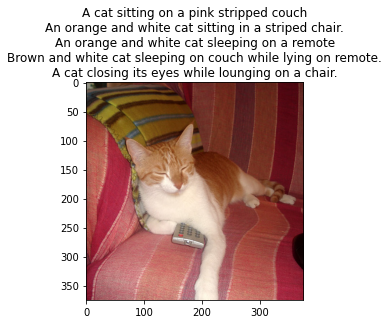

In [19]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

In [20]:

# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [21]:
from collections import Counter
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    words = [sentence for captions in train_captions for sentence in captions]
    words = split_sentence(' '.join(words))
    
    count = Counter(words)
    vocab = [token for token, count in count.items() if count >= 5]
    
    vocab.extend([PAD, UNK, START, END]) ### YOUR CODE HERE ###
    return {token: index for index, token in enumerate(sorted(vocab))}

    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    
    res = [[[vocab[START]] + [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] + [vocab[END]] for sentence in caption] for caption in captions] ### YOUR CODE HERE ###
    return res

In [22]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [23]:

# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [24]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len is None:
        max_len = max(map(len, batch_captions))
    else:
        max_len = min(max_len, max(map(len, batch_captions)))
    
    matrix = [[index for i, index in enumerate(caption[:max_len])] + [pad_idx]*(max(max_len-len(caption),0)) for caption in batch_captions] ###YOUR CODE HERE###
    return np.array(matrix)

In [25]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [26]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [27]:

# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

In [28]:

IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [30]:

# remember to reset your graph if you want to start building it from scratch!
s = tf.compat.v1.Session()
tf.set_random_seed(42)

In [31]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds)) ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1]) ### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS]) ### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states)) ### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1,]) ### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) ### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask)) ### YOUR CODE HERE ###

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [32]:

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [33]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [34]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [35]:

train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    batch = np.random.choice(len(images_embeddings), batch_size, replace=False)
    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[batch]]
    
    batch_image_embeddings = images_embeddings[batch]
    
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    ### YOUR CODE HERE ###
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [37]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [38]:
# you can load trained weights here
# uncomment the next line if you need to load weights
# saver.restore(s, get_checkpoint_path(epoch=4))

In [39]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.239854
Epoch: 0, train loss: 4.2398537187576295, val loss: 3.6140334177017213
**************************************************
Training loss: 3.276860
Epoch: 1, train loss: 3.2768602919578553, val loss: 3.0738787770271303
**************************************************
Training loss: 2.979963
Epoch: 2, train loss: 2.9799630448818206, val loss: 2.9328719449043272
**************************************************
Training loss: 2.835820
Epoch: 3, train loss: 2.8358200902938844, val loss: 2.839642803668976
**************************************************
Training loss: 2.751022
Epoch: 4, train loss: 2.751022229671478, val loss: 2.7834534645080566
**************************************************
Training loss: 2.689836
Epoch: 5, train loss: 2.689836232185364, val loss: 2.7308420729637146
Instructions for updating:
Use standard file APIs to delete files with this prefix.
*******************************************

In [40]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************



In [41]:
# you can make submission with answers so far to check yourself at this stage
COURSERA_TOKEN = 'zGmyMRVegWXddqVy'
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [49]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    
    with sess.as_default()

     logits = decoder.flat_token_logits.eval(fd)
     truth = decoder.flat_ground_truth.eval(fd)
     mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

SyntaxError: ignored

In [50]:

# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/MyDrive/colab/weights'

In [51]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:Restoring parameters from /content/gdrive/MyDrive/colab/weights


In [52]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [53]:
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

FailedPreconditionError: ignored

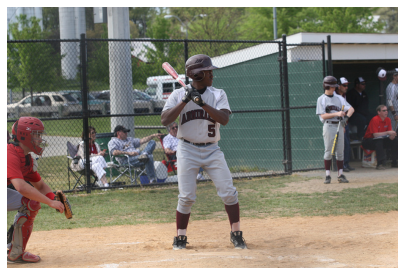

In [54]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

FailedPreconditionError: ignored

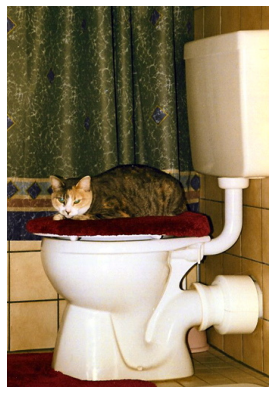

In [55]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

In [56]:

download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

**************************************************
portal-cake-10.jpg


FailedPreconditionError: ignored

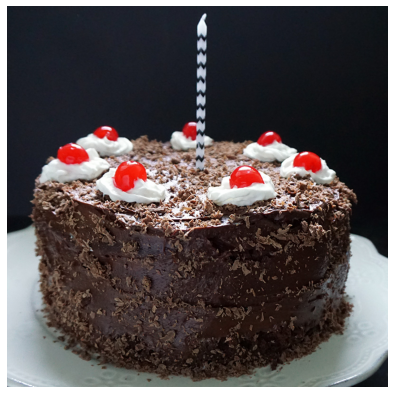

In [57]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())